# Object Detection Multi-Class Rider, Helm, dan Plat Nomor Kendaraan Bermotor dengan YOLOv8

###NIM : 22.11.4613
###Nama : Alvin Christ Yudantama
###Kelas : PDM07

#Load Dataset

In [ ]:
# Mount Dataset Dari Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = "/content/drive/MyDrive/Semester6/ProyekDataMining/Dataset"

#Data Inspection & Visualization

In [ ]:
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint
import os
import cv2
from matplotlib import pyplot as plt

# Pemetaan class ID ke nama label
id2class_map = {
    '0': 'with helmet',
    '1': 'without helmet',
    '2': 'rider',
    '3': 'number_plate'
}

# Menampilkan jumlah data (file .txt) per split
def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')

# Menampilkan jumlah masing-masing class berdasarkan isi file .txt
def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

# Tampilkan jumlah data dan distribusi kelas
print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



In [ ]:
# Fungsi untuk visualisasi bounding box dari data anotasi YOLO
def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
    bboxes = [[float(n) for n in line.split()[1:]] for line in lines]
    labels = [id2class_map[line.split()[0]] for line in lines]
    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2
    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)
    return x_min, y_min, x_max, y_max

# Peta warna untuk visualisasi
class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

# Fungsi untuk plotting gambar dan bounding box-nya
def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        img = cv2.putText(
            img,
            label,
            (x_min, y_min + 10),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
            fontScale = 0.6,
            color = color,
            thickness=2
        )
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Image: new36


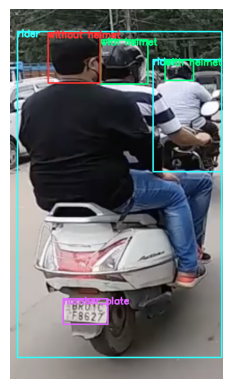


Image: new10


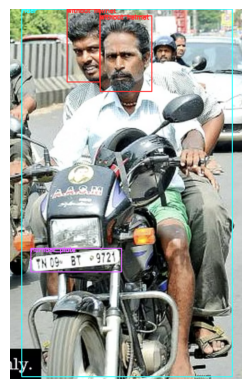


Image: new112


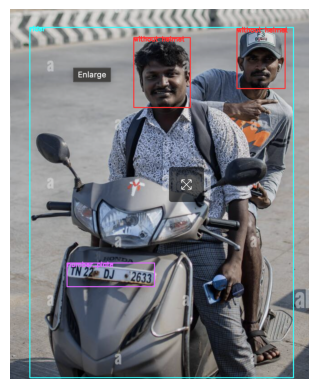


Image: new103


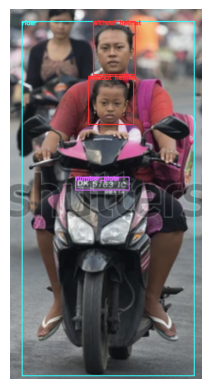


Image: new15


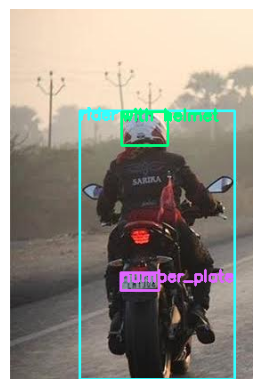

In [ ]:
# Ambil 5 nama file pertama dari folder images
image_files = glob(f"{main_path}/train/images/*.jpg")
image_names = [os.path.splitext(os.path.basename(f))[0] for f in image_files[:5]]

# Tampilkan gambar-gambar tersebut dengan bounding box-nya
for name in image_names:
    print(f'\nImage: {name}')
    plot_image(image_name=name)

#Preprocessing

In [ ]:
from tqdm import tqdm

# 1. Cek pasangan file gambar dan label
def check_image_label_pairs(folder_type):
    img_files = set(os.path.splitext(f)[0] for f in os.listdir(f'{main_path}/{folder_type}/images') if f.endswith('.jpg'))
    lbl_files = set(os.path.splitext(f)[0] for f in os.listdir(f'{main_path}/{folder_type}/labels') if f.endswith('.txt'))

    missing_labels = img_files - lbl_files
    missing_images = lbl_files - img_files

    print(f"\n[{folder_type.upper()}] Jumlah gambar: {len(img_files)}, Jumlah label: {len(lbl_files)}")
    print(f" - Gambar tanpa label : {len(missing_labels)} → {list(missing_labels)[:3]}")
    print(f" - Label tanpa gambar : {len(missing_images)} → {list(missing_images)[:3]}")

check_image_label_pairs('train')
check_image_label_pairs('val')


# 2. Cek validitas class ID dan bounding box range
def validate_labels(folder_type):
    invalid_class_count = 0
    invalid_bbox_count = 0
    for file in tqdm(glob(f'{main_path}/{folder_type}/labels/*.txt')):
        with open(file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id, *bbox = parts
            if class_id not in id2class_map:
                invalid_class_count += 1
            if not all(0 <= float(x) <= 1 for x in map(float, bbox)):
                invalid_bbox_count += 1
    print(f"\n[{folder_type.upper()}] Label tidak valid:")
    print(f" - Class ID diluar jangkauan: {invalid_class_count}")
    print(f" - Koordinat bbox tidak dalam rentang [0, 1]: {invalid_bbox_count}")

validate_labels('train')
validate_labels('val')


[TRAIN] Jumlah gambar: 104, Jumlah label: 104
 - Gambar tanpa label : 0 → []
 - Label tanpa gambar : 0 → []

[VAL] Jumlah gambar: 20, Jumlah label: 20
 - Gambar tanpa label : 0 → []
 - Label tanpa gambar : 0 → []


100%|██████████| 104/104 [00:00<00:00, 362.02it/s]



[TRAIN] Label tidak valid:
 - Class ID diluar jangkauan: 0
 - Koordinat bbox tidak dalam rentang [0, 1]: 0


100%|██████████| 20/20 [00:00<00:00, 353.19it/s]


[VAL] Label tidak valid:
 - Class ID diluar jangkauan: 0
 - Koordinat bbox tidak dalam rentang [0, 1]: 0


#EDA

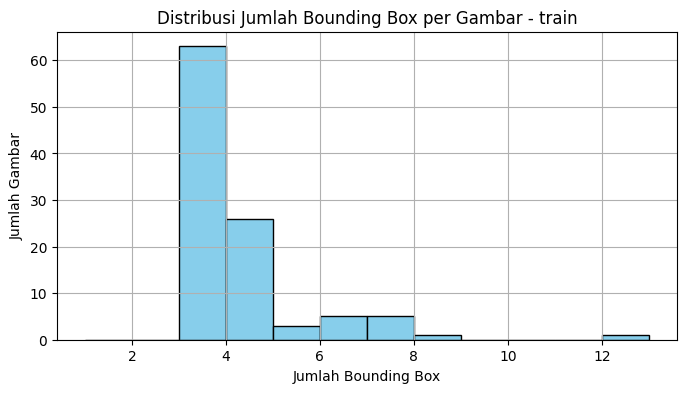

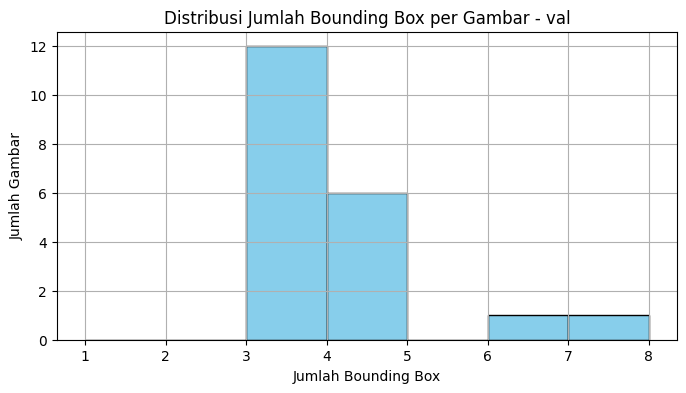

In [ ]:
from glob import glob
import matplotlib.pyplot as plt

def plot_bbox_distribution(folder_type='train'):
    label_paths = glob(f'{main_path}/{folder_type}/labels/*.txt')
    bbox_counts = [len(open(p).readlines()) for p in label_paths]

    plt.figure(figsize=(8, 4))
    plt.hist(bbox_counts, bins=range(1, max(bbox_counts)+2), color='skyblue', edgecolor='black')
    plt.title(f'Distribusi Jumlah Bounding Box per Gambar - {folder_type}')
    plt.xlabel('Jumlah Bounding Box')
    plt.ylabel('Jumlah Gambar')
    plt.grid(True)
    plt.show()

plot_bbox_distribution('train')
print("")
plot_bbox_distribution('val')

Gambar dengan jumlah bounding box terbanyak: new6 (12 bbox)


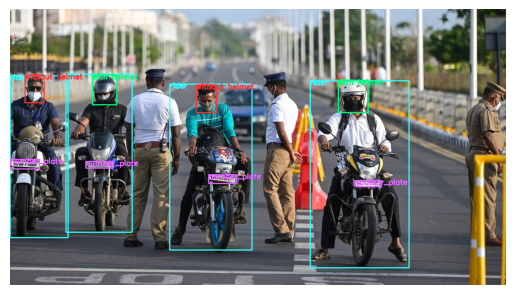

In [ ]:
# Hitung jumlah bounding box untuk setiap gambar
bbox_count_per_image = {}

for file in glob(f"{main_path}/train/labels/*.txt"):
    image_name = os.path.splitext(os.path.basename(file))[0]
    with open(file, 'r') as f:
        num_bboxes = len(f.readlines())
    bbox_count_per_image[image_name] = num_bboxes

# Cari gambar dengan jumlah bbox terbanyak
max_bbox_image = max(bbox_count_per_image, key=bbox_count_per_image.get)
max_bbox_count = bbox_count_per_image[max_bbox_image]

print(f"Gambar dengan jumlah bounding box terbanyak: {max_bbox_image} ({max_bbox_count} bbox)")

# Tampilkan gambar tersebut
plot_image(image_name=max_bbox_image)

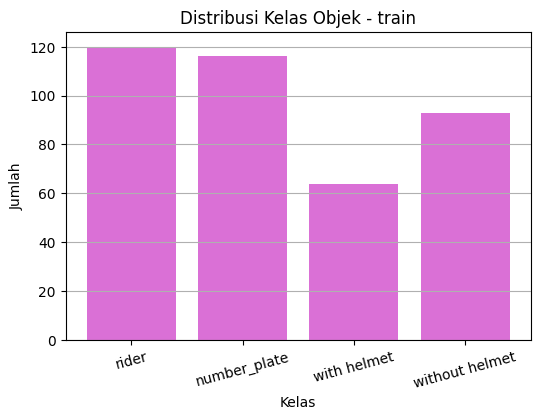

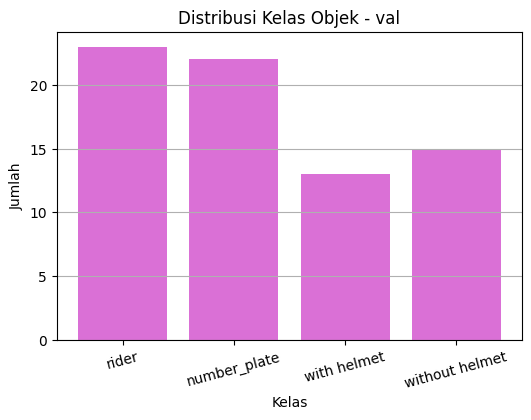

In [ ]:
def plot_class_distribution(folder_type='train'):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.extend([row.split()[0] for row in open(file, "r")])
    counter = Counter(class_list)

    labels = [id2class_map[k] for k in counter.keys()]
    values = list(counter.values())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color='orchid')
    plt.title(f'Distribusi Kelas Objek - {folder_type}')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=15)
    plt.grid(True, axis='y')
    plt.show()

plot_class_distribution('train')
print("")
plot_class_distribution('val')

TRAIN: 100%|██████████| 104/104 [00:00<00:00, 385.58it/s]


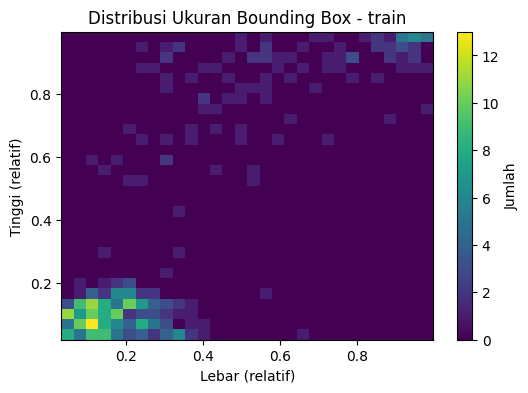

VAL: 100%|██████████| 20/20 [00:00<00:00, 307.33it/s]


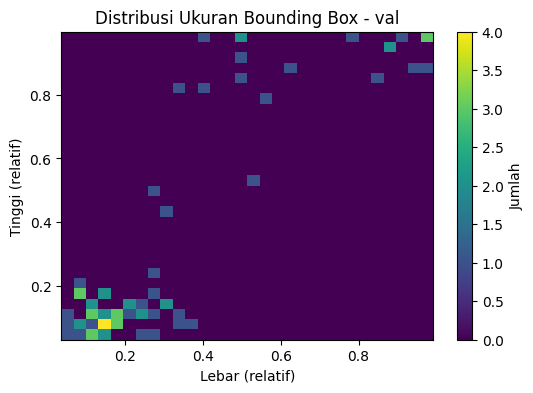

In [ ]:
import numpy as np
from tqdm import tqdm

def bbox_size_distribution(folder_type='train'):
    widths = []
    heights = []
    label_paths = glob(f'{main_path}/{folder_type}/labels/*.txt')

    for path in tqdm(label_paths, desc=f'{folder_type.upper()}'):
        with open(path, 'r') as f:
            for line in f:
                _, x_center, y_center, width, height = map(float, line.strip().split())
                widths.append(width)
                heights.append(height)

    plt.figure(figsize=(6, 4))
    plt.hist2d(widths, heights, bins=30, cmap='viridis')
    plt.colorbar(label='Jumlah')
    plt.xlabel('Lebar (relatif)')
    plt.ylabel('Tinggi (relatif)')
    plt.title(f'Distribusi Ukuran Bounding Box - {folder_type}')
    plt.show()

bbox_size_distribution('train')
print("")
bbox_size_distribution('val')

#Feature Extraction & Selection

In [ ]:
def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)

    if image is None:
        print(f"⚠️ Warning: Image not found at {img_path}")
        return None  # kembalikan None jika tidak ada

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Fungsi untuk menghitung brightness
def calculate_brightness(img):
    # Konversi ke grayscale lalu hitung rata-rata pixel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.mean(gray)

def extract_features(image_names, data_type='train'):
    feature_list = []

    for name in tqdm(image_names, desc=f'Extracting features [{data_type}]'):
        img = load_image(image_name=name, data_type=data_type)

        if img is None:
            continue  # Skip gambar yang tidak ada / gagal dibaca

        bboxes, labels = get_bbox_and_label(image_name=name, data_type=data_type)

        img_height, img_width, _ = img.shape
        bbox_count = len(bboxes)

        bbox_areas = []
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)
            area = (x_max - x_min) * (y_max - y_min)
            bbox_areas.append(area)

        avg_bbox_area = np.mean(bbox_areas) if bbox_areas else 0
        total_bbox_area = np.sum(bbox_areas) if bbox_areas else 0
        object_density = total_bbox_area / (img_width * img_height)
        brightness = calculate_brightness(img)

        feature_list.append({
            'image_name': name,
            'image_width': img_width,
            'image_height': img_height,
            'bbox_count': bbox_count,
            'avg_bbox_area': avg_bbox_area,
            'object_density': object_density,
            'brightness': brightness
        })

    return pd.DataFrame(feature_list)

# Ambil semua nama file gambar
train_image_files = glob(f"{main_path}/train/images/*.jpg")
train_image_names = [os.path.splitext(os.path.basename(f))[0] for f in train_image_files]

# Ekstrak fitur
train_features_df = extract_features(train_image_names, data_type='train')

# Lihat hasil
train_features_df.head()

Extracting features [train]:  12%|█▎        | 13/104 [00:00<00:02, 34.39it/s]

⚠️ Warning: Image not found at /content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/train/images/new128.jpg
⚠️ Warning: Image not found at /content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/train/images/new3.jpg


Extracting features [train]: 100%|██████████| 104/104 [00:04<00:00, 24.34it/s]


image_name  image_width  image_height  bbox_count  avg_bbox_area  \
0      new36          410           713           6   49851.666667   
1      new10          660          1052           4  173524.250000   
2     new112          820          1016           4  190666.500000   
3     new103          560          1082           4  140845.250000   
4      new15          273           416           3   18461.333333   

   object_density  brightness  
0        1.023193   97.715305  
1        0.999679  152.787130  
2        0.915434  119.538679  
3        0.929794   98.010902  
4        0.487673  132.190344

# YOLOv8

## 1. Backbone (Feature Extraction)
#### Tujuan : Mengambil fitur visual dari gambar (seperti tepi, bentuk, pola).

#### Struktur :
1. Convolution → BatchNorm → Activation (SiLU) <br>
2. C2f : modul khas YOLOv8 untuk feature reuse (mirip residual block) <br>
3. Downsampling dengan stride=2 convolution → mengurangi ukuran gambar, meningkatkan receptive field <br>
4. Mirip seperti EfficientNet atau CSPDarknet

## 2. Neck (Feature Fusion)
#### Tujuan : Menggabungkan fitur dari berbagai resolusi agar deteksi lebih akurat untuk objek kecil dan besar.

#### Struktur :
1. FPN (Feature Pyramid Network) dan PAN (Path Aggregation Network) <br>
2. Upsample dan downsample untuk menggabungkan : <br>
fitur resolusi tinggi (objek kecil)<br>
fitur resolusi rendah (objek besar)

## 3. Head (Detection Output)
#### Tujuan : **Menghasilkan prediksi akhir**
- Bounding box (x, y, w, h)
- Confidence score
- Class probabilities

#### Struktur :
- Conv layer per scale
- Output untuk 3 skala (deteksi multi-size)
- No anchor box (YOLOv8 adalah anchor-free unlike YOLOv5)

## Flow
1. Preprocessing :
Resize → Normalisasi → Format tensor (NCHW)
2. Backbone : Ekstrak fitur
3. Neck : Gabungkan fitur dari berbagai skala
4. Head : Prediksi bbox dan kelas
5. Postprocessing : Non-Max Suppression (NMS) untuk hilangkan bbox tumpang tindih

https://yolov8.org/yolov8-architecture/

In [ ]:
!pip install ultralytics

from ultralytics import YOLO

# Load model YOLOv8 (bisa pilih -n, -s, -m, -l, atau -x sesuai kebutuhan)
model = YOLO('yolov8n.pt')  # 'n' artinya nano, ringan untuk eksperimen awal

# Train
model.train(
    data="/content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/dataset.yaml",
    epochs=50,
    imgsz=640,  # ukuran gambar setelah resize otomatis
    batch=16,   # sesuaikan kapasitas GPU
    name = "helmet_detection_model"  # folder save hasil training
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

100%|██████████| 6.25M/6.25M [00:00<00:00, 293MB/s]


Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=helmet_detection_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

100%|██████████| 755k/755k [00:00<00:00, 119MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 95.9±104.9 MB/s, size: 554.2 KB)


train: Scanning /content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/train/labels.cache... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/train/images/new128.jpg'
train: /content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'dng', 'tif', 'mpo', 'jpg', 'heic', 'tiff', 'bmp', 'webp', 'jpeg', 'png', 'pfm'}
videos: {'m4v', 'mpeg', 'mov', 'ts', 'mp4', 'avi', 'mkv', 'gif', 'webm', 'mpg', 'asf', 'wmv'}


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 1.8±1.8 MB/s, size: 695.8 KB)


val: Scanning /content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs/detect/helmet_detection_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/helmet_detection_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.106      3.597      1.341         43        640: 100%|██████████| 7/7 [01:35<00:00, 13.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.70s/it]

                   all         20         73     0.0102      0.413      0.171      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.9177      3.034      1.163         46        640: 100%|██████████| 7/7 [01:25<00:00, 12.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.59s/it]

                   all         20         73     0.0243      0.438       0.23      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.8589      1.866       1.13         51        640: 100%|██████████| 7/7 [01:25<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]

                   all         20         73     0.0512      0.402      0.242       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.8736      1.452      1.139         37        640: 100%|██████████| 7/7 [01:27<00:00, 12.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]

                   all         20         73      0.104       0.82      0.615      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.8281      1.256      1.092         34        640: 100%|██████████| 7/7 [01:32<00:00, 13.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]

                   all         20         73      0.969      0.207      0.632      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8122      1.193      1.067         28        640: 100%|██████████| 7/7 [01:32<00:00, 13.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]

                   all         20         73      0.948      0.168      0.703      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.8074      1.072      1.032         51        640: 100%|██████████| 7/7 [01:33<00:00, 13.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]

                   all         20         73      0.925      0.201      0.633      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.7939      1.032      1.053         45        640: 100%|██████████| 7/7 [01:32<00:00, 13.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.12s/it]

                   all         20         73      0.934      0.222      0.632      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.7862     0.9557       1.04         41        640: 100%|██████████| 7/7 [01:32<00:00, 13.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.44s/it]

                   all         20         73      0.942      0.249      0.713      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.8496     0.9587      1.066         50        640: 100%|██████████| 7/7 [01:31<00:00, 13.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]

                   all         20         73      0.917      0.297      0.643      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      0.778     0.9157      1.023         45        640: 100%|██████████| 7/7 [01:31<00:00, 13.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]

                   all         20         73      0.916      0.286      0.654      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      0.768     0.8733       1.03         32        640: 100%|██████████| 7/7 [01:30<00:00, 12.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.55s/it]

                   all         20         73      0.924      0.517      0.785      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.7721     0.8627      1.023         47        640: 100%|██████████| 7/7 [01:23<00:00, 11.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]

                   all         20         73      0.866      0.521      0.794      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.7462     0.8507       1.04         45        640: 100%|██████████| 7/7 [01:25<00:00, 12.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]

                   all         20         73      0.824      0.642      0.849      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.7302      0.827      1.008         45        640: 100%|██████████| 7/7 [01:28<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]

                   all         20         73        0.8      0.765      0.861      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.7215     0.8079      1.006         38        640: 100%|██████████| 7/7 [01:24<00:00, 12.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]

                   all         20         73      0.775      0.823      0.864      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.7455     0.8189     0.9944         59        640: 100%|██████████| 7/7 [01:27<00:00, 12.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]

                   all         20         73      0.775      0.822      0.884      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.7443     0.8124      1.002         43        640: 100%|██████████| 7/7 [01:26<00:00, 12.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]

                   all         20         73      0.902      0.842      0.925      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.7007     0.7834     0.9846         39        640: 100%|██████████| 7/7 [01:24<00:00, 12.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]

                   all         20         73      0.881      0.878      0.918      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.6987      0.779     0.9978         48        640: 100%|██████████| 7/7 [01:25<00:00, 12.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]

                   all         20         73      0.911       0.89      0.929      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.7063     0.7743      1.031         41        640: 100%|██████████| 7/7 [01:26<00:00, 12.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]

                   all         20         73      0.906      0.884      0.933      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.6755     0.7301     0.9769         52        640: 100%|██████████| 7/7 [01:25<00:00, 12.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]

                   all         20         73      0.921      0.903      0.922      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.6855     0.7129     0.9835         41        640: 100%|██████████| 7/7 [01:26<00:00, 12.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]

                   all         20         73      0.944      0.917      0.926      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.6553      0.696     0.9761         53        640: 100%|██████████| 7/7 [01:28<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]

                   all         20         73      0.926        0.9      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.6574     0.6896      0.988         47        640: 100%|██████████| 7/7 [01:26<00:00, 12.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]

                   all         20         73      0.921      0.896      0.932       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.6527     0.6759     0.9581         57        640: 100%|██████████| 7/7 [01:25<00:00, 12.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]

                   all         20         73      0.932      0.897      0.941       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.6435     0.6705     0.9676         53        640: 100%|██████████| 7/7 [01:27<00:00, 12.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]

                   all         20         73      0.942       0.95       0.94      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.6109     0.6489     0.9582         41        640: 100%|██████████| 7/7 [01:26<00:00, 12.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]

                   all         20         73      0.944      0.945      0.944      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.6037     0.6649     0.9556         31        640: 100%|██████████| 7/7 [01:26<00:00, 12.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.03s/it]

                   all         20         73      0.951      0.932       0.95      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.6349     0.6511     0.9642         49        640: 100%|██████████| 7/7 [01:26<00:00, 12.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.71s/it]

                   all         20         73      0.931      0.941      0.954      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      0.645     0.6619     0.9722         49        640: 100%|██████████| 7/7 [01:26<00:00, 12.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.22s/it]

                   all         20         73      0.931      0.913      0.944      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      0.589     0.6178     0.9578         37        640: 100%|██████████| 7/7 [01:25<00:00, 12.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]

                   all         20         73      0.941      0.886      0.927      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.6433      0.658     0.9866         46        640: 100%|██████████| 7/7 [01:26<00:00, 12.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]

                   all         20         73      0.912       0.91       0.92      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.6082     0.6281      0.958         41        640: 100%|██████████| 7/7 [01:28<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.39s/it]

                   all         20         73      0.924      0.897       0.93      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.5845     0.6135     0.9472         32        640: 100%|██████████| 7/7 [01:27<00:00, 12.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]

                   all         20         73      0.924      0.906      0.929      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.5949     0.6204     0.9649         52        640: 100%|██████████| 7/7 [01:27<00:00, 12.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]

                   all         20         73      0.924      0.915      0.923       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.6168     0.6064     0.9481         45        640: 100%|██████████| 7/7 [01:28<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]

                   all         20         73      0.924      0.914      0.925       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.5724     0.6068     0.9493         34        640: 100%|██████████| 7/7 [01:28<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.83s/it]

                   all         20         73      0.927      0.917      0.935      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.5778     0.5931     0.9561         34        640: 100%|██████████| 7/7 [01:28<00:00, 12.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.09s/it]

                   all         20         73       0.94      0.903      0.935      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.5523     0.5663     0.9493         41        640: 100%|██████████| 7/7 [01:26<00:00, 12.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]

                   all         20         73      0.936      0.905       0.94      0.773


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.5401     0.7619      0.878         19        640: 100%|██████████| 7/7 [01:26<00:00, 12.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]

                   all         20         73      0.937      0.904      0.942      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.5185     0.6782     0.8925         20        640: 100%|██████████| 7/7 [01:26<00:00, 12.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.44s/it]

                   all         20         73      0.942      0.902      0.937      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      0.538     0.6962     0.9045         22        640: 100%|██████████| 7/7 [01:26<00:00, 12.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]

                   all         20         73      0.944      0.886       0.93      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.5357     0.6721     0.8866         18        640: 100%|██████████| 7/7 [01:26<00:00, 12.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]

                   all         20         73      0.915      0.921      0.917      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.5051     0.6454     0.8823         21        640: 100%|██████████| 7/7 [01:26<00:00, 12.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.29s/it]

                   all         20         73      0.943      0.887      0.915      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.4997     0.6342     0.8817         27        640: 100%|██████████| 7/7 [01:25<00:00, 12.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]

                   all         20         73      0.944      0.885      0.916      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.5086     0.6172     0.8714         24        640: 100%|██████████| 7/7 [01:27<00:00, 12.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]

                   all         20         73      0.912      0.924      0.926      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.4871     0.5964     0.8642         20        640: 100%|██████████| 7/7 [01:27<00:00, 12.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]

                   all         20         73      0.911      0.924      0.931      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.4728     0.5766     0.8578         27        640: 100%|██████████| 7/7 [01:25<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]

                   all         20         73      0.911      0.925      0.931      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.4959     0.6186      0.892         21        640: 100%|██████████| 7/7 [01:25<00:00, 12.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]

                   all         20         73      0.942      0.884       0.93      0.776



50 epochs completed in 1.317 hours.
Optimizer stripped from runs/detect/helmet_detection_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/helmet_detection_model/weights/best.pt, 6.2MB

Validating runs/detect/helmet_detection_model/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


                   all         20         73      0.942      0.902      0.937      0.779
           with helmet         12         13      0.979      0.846      0.922      0.682
        without helmet         10         15      0.822      0.924      0.872      0.711
                 rider         20         23      0.967      0.913      0.962      0.884
          number plate         20         22          1      0.924       0.99      0.837
Speed: 2.8ms preprocess, 241.1ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/helmet_detection_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d746c51e890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Hasil
Precision (P) = Ketepatan prediksi <br>
Recall (R) = Kemampuan menangkap semua objek <br>
mAP50 = Mean Average Precision dengan IoU threshold 50% <br>
mAP50-95 = Rata-rata mAP dari IoU 50% sampai 95% <br>

### All
- Precision (P) = 0.942
- Recall (R) = 902
- mAP50 = 0.937
- mAP50-95 = 0.779

### With helmet
- Precision (P) = 0.979
- Recall (R) = 0.846
- mAP50 = 0.922
- mAP50-95 = 0.682

### Without helmet
- Precision (P) = 0.822
- Recall (R) = 	0.924
- mAP50 = 0.872
- mAP50-95 = 0.711

### Rider
- Precision (P) = 0.967
- Recall (R) = 0.913
- mAP50 = 0.962
- mAP50-95 = 0.884

### Plate
- Precision (P) = 1.000
- Recall (R) = 0.924
- mAP50 = 0.990
- mAP50-95 = 0.837


In [ ]:
from ultralytics import YOLO

# Load model terlatih
model = YOLO('/content/runs/detect/helmet_detection_model/weights/best.pt')

In [ ]:
import shutil

shutil.copy(
    '/content/runs/detect/helmet_detection_model/weights/best.pt',
    '/content/drive/MyDrive/Semester6/ProyekDataMining/Model/best_model.pt'
)

'/content/drive/MyDrive/Semester6/ProyekDataMining/Model/best_model.pt'

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/Semester6/ProyekDataMining/Model/best_model.pt')

  Using cached ultralytics-8.3.152-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.

In [ ]:
import os
from ultralytics import YOLO
from IPython.display import display, Image
from glob import glob
import shutil

# Load model
model = YOLO('/content/drive/MyDrive/Semester6/ProyekDataMining/Model/best_model.pt')

# Ambil 5 gambar pertama dari folder test
test_folder = '/content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/val/images'
image_paths = sorted(glob(f"{test_folder}/*.jpg"))[:5]

# Lakukan prediksi dan simpan hasil
results = model(image_paths, save=True)


0: 640x640 2 without helmets, 1 rider, 225.8ms
1: 640x640 2 with helmets, 1 rider, 1 number plate, 225.8ms
2: 640x640 1 with helmet, 1 rider, 1 number plate, 225.8ms
3: 640x640 2 without helmets, 2 riders, 2 number plates, 225.8ms
4: 640x640 1 without helmet, 1 rider, 1 number plate, 225.8ms
Speed: 11.9ms preprocess, 225.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


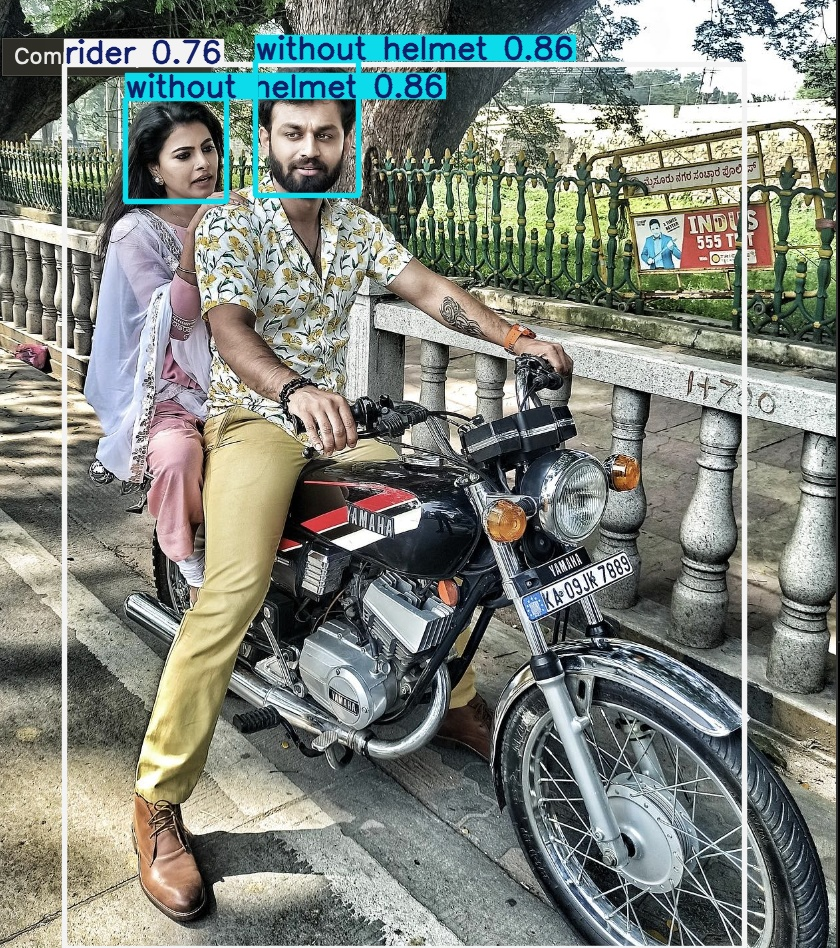

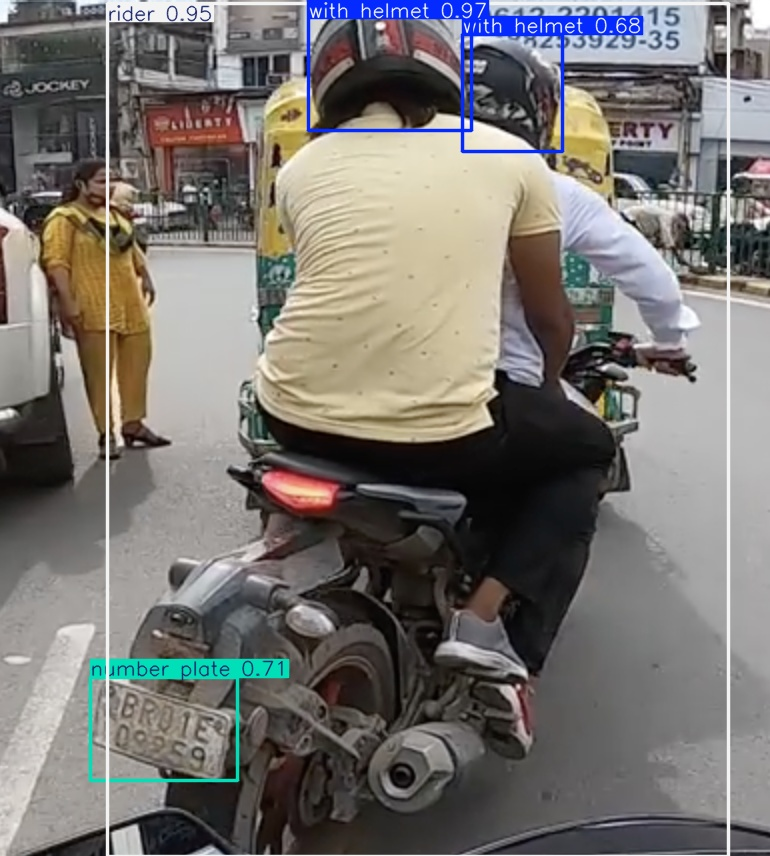

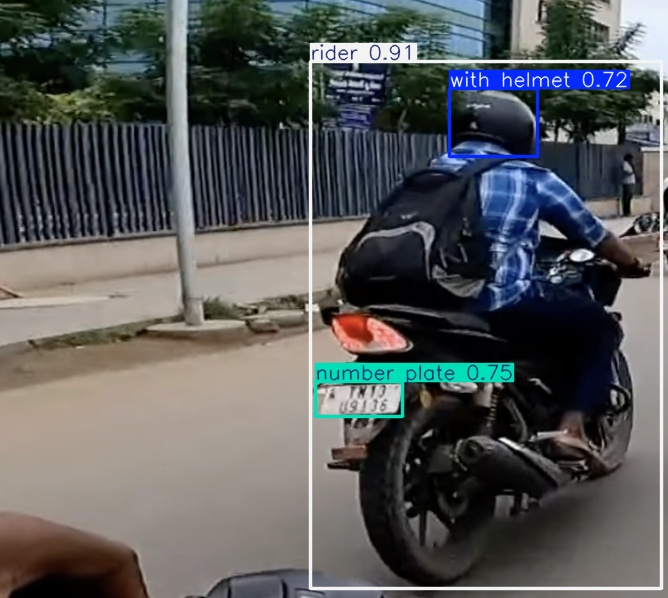

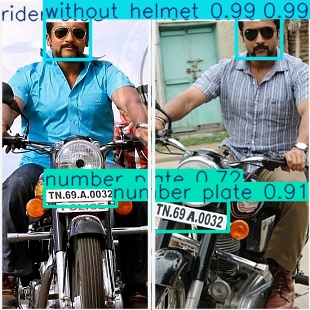

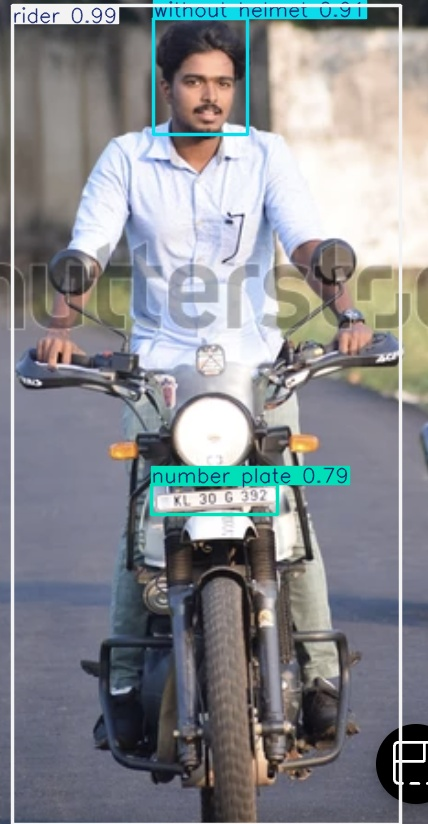

In [ ]:
# Tampilkan hasil prediksi (hasil otomatis disimpan ke runs/detect/predict/)
predict_folder = 'runs/detect/predict'

for path in image_paths:
    filename = os.path.basename(path)
    result_path = os.path.join(predict_folder, filename)
    display(Image(filename=result_path))

In [ ]:
import os
from ultralytics import YOLO
from IPython.display import display, Image
from glob import glob
import shutil

# Load model
model = YOLO('/content/drive/MyDrive/Semester6/ProyekDataMining/Model/best_model.pt')

# Ambil 5 gambar pertama dari folder test
test_folder = '/content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/val/images'
image_paths = sorted(glob(f"{test_folder}/*.jpg"))[:5]

# Lakukan prediksi dan simpan hasil
results = model(image_paths, save=True, conf=0.1)


0: 640x640 2 without helmets, 1 rider, 1 number plate, 195.7ms
1: 640x640 2 with helmets, 1 rider, 1 number plate, 195.7ms
2: 640x640 1 with helmet, 1 rider, 1 number plate, 195.7ms
3: 640x640 2 without helmets, 2 riders, 2 number plates, 195.7ms
4: 640x640 1 without helmet, 1 rider, 1 number plate, 195.7ms
Speed: 4.1ms preprocess, 195.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


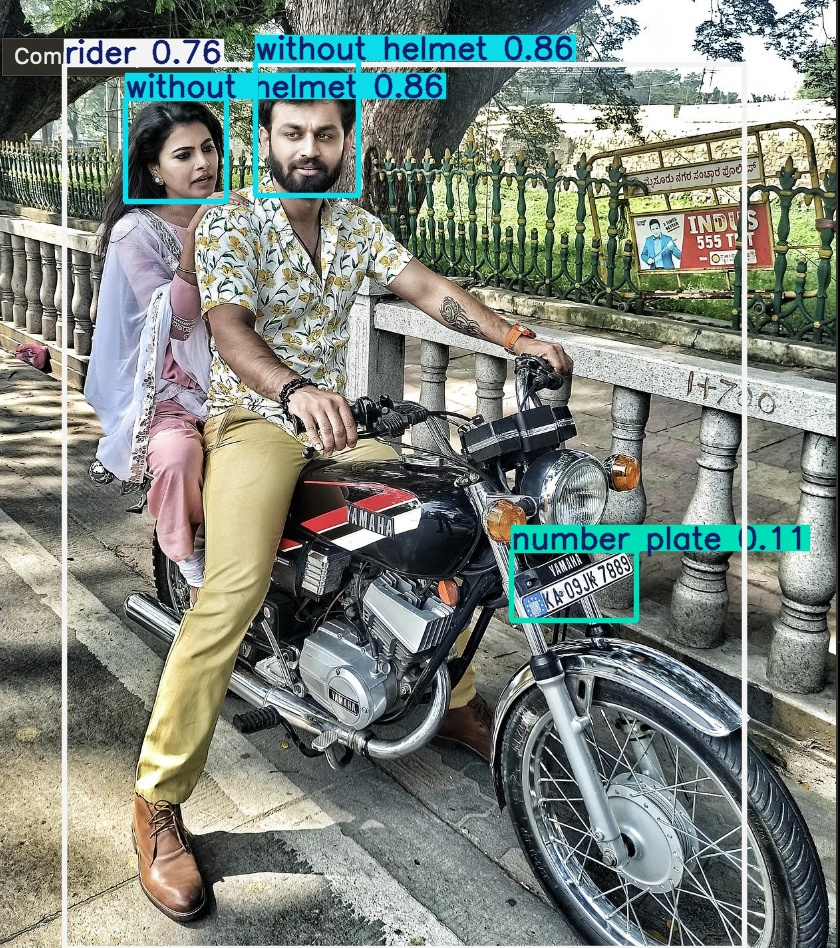

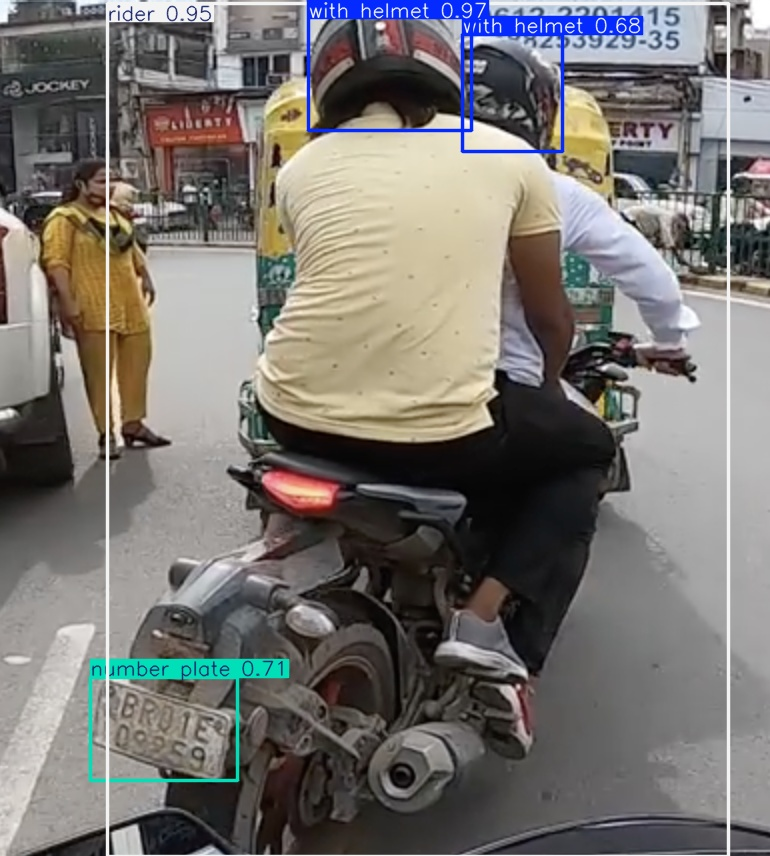

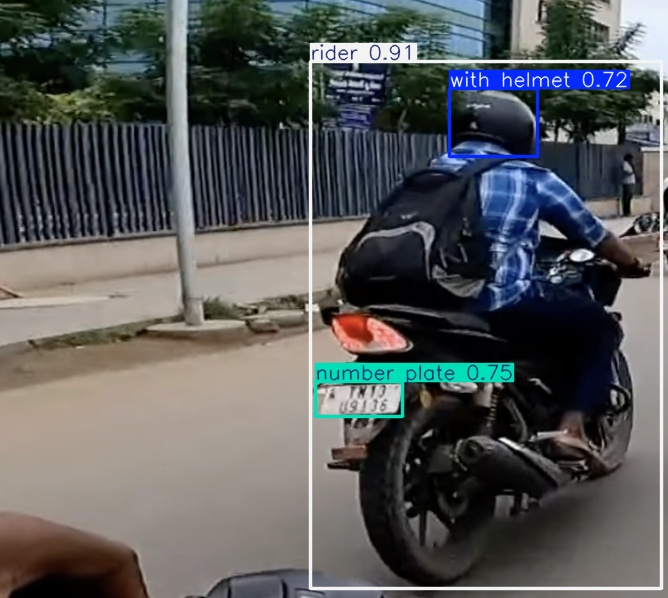

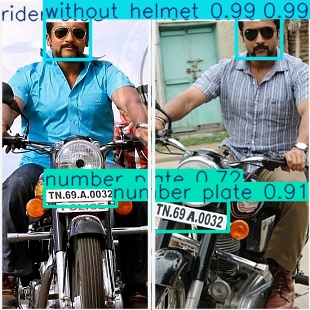

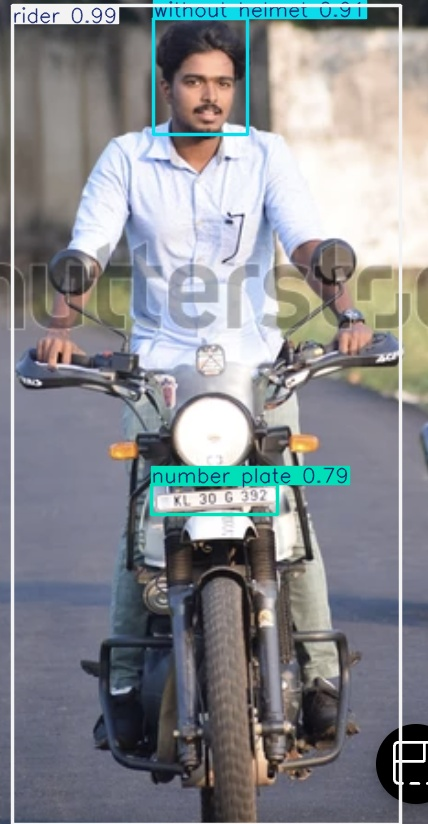

In [ ]:
# Tampilkan hasil prediksi (hasil otomatis disimpan ke runs/detect/predict/)
predict_folder = 'runs/detect/predict2'

for path in image_paths:
    filename = os.path.basename(path)
    result_path = os.path.join(predict_folder, filename)
    display(Image(filename=result_path))

In [ ]:
from ultralytics import YOLO

# Load the model
model = YOLO('/content/drive/MyDrive/Semester6/ProyekDataMining/Model/best_model.pt')

# Run the evaluation
results = model.val(data="/content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/dataset.yaml")

# Print specific metrics
print("Class indices with average precision:", results.ap_class_index)
print("Average precision for all classes:", results.box.all_ap)
print("Average precision:", results.box.ap)
print("Average precision at IoU=0.50:", results.box.ap50)
print("Class indices for average precision:", results.box.ap_class_index)
print("Class-specific results:", results.box.class_result)
print("F1 score:", results.box.f1)
print("F1 score curve:", results.box.f1_curve)
print("Overall fitness score:", results.box.fitness)
print("Mean average precision:", results.box.map)
print("Mean average precision at IoU=0.50:", results.box.map50)
print("Mean average precision at IoU=0.75:", results.box.map75)
print("Mean average precision for different IoU thresholds:", results.box.maps)
print("Mean results for different metrics:", results.box.mean_results)
print("Mean precision:", results.box.mp)
print("Mean recall:", results.box.mr)
print("Precision:", results.box.p)
print("Precision curve:", results.box.p_curve)
print("Precision values:", results.box.prec_values)
print("Specific precision metrics:", results.box.px)
print("Recall:", results.box.r)
print("Recall curve:", results.box.r_curve)

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.8±0.7 MB/s, size: 419.4 KB)


val: Scanning /content/drive/MyDrive/Semester6/ProyekDataMining/Dataset/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.63s/it]


                   all         20         73      0.946      0.912      0.952      0.799
           with helmet         12         13          1      0.872      0.973      0.733
        without helmet         10         15      0.821      0.933      0.876      0.725
                 rider         20         23      0.961      0.913      0.967      0.901
          number plate         20         22          1      0.929      0.993      0.837
Speed: 22.7ms preprocess, 338.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val2
Class indices with average precision: [0 1 2 3]
Average precision for all classes: [[    0.97289     0.97289     0.97289     0.97289     0.97289     0.97289     0.83158     0.44857      0.1961    0.015231]
 [    0.87602     0.87602     0.87602     0.87602     0.87602     0.86044     0.83345     0.73764     0.30119     0.13556]
 [    0.96724     0.96724     0.96724     0.96724     0.96724     0.96724     0.96724     0.93181     0.866

In [ ]:
# Folder tujuan di Google Drive
save_dir = '/content/drive/MyDrive/Semester6/ProyekDataMining/Hasil'

# Pastikan folder tujuan ada
os.makedirs(save_dir, exist_ok=True)

# Salin hasil prediksi ke Google Drive
for path in image_paths:
    filename = os.path.basename(path)
    src = os.path.join(predict_folder, filename)
    dst = os.path.join(save_dir, filename)
    shutil.copy(src, dst)

print("✅ Hasil prediksi disimpan di:", save_dir)

✅ Hasil prediksi disimpan di: /content/drive/MyDrive/Semester6/ProyekDataMining/Hasil
